In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.backends.cudnn as cudnn
import torchvision
import torch.autograd as autograd
from pathlib import Path

import imp
import os
import sys
import math
import time
import random
import shutil

from tqdm import tqdm
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('bmh')

import utils.training as train_utils; imp.reload(train_utils)
#import utils.plot as plot_utils; imp.reload(plot_utils)

import camvid_dataset as camvid
import joint_transforms
%matplotlib inline

In [2]:
DATA_PATH='/data/code/SegNet-Tutorial/'
RESULTS_PATH='results/'
WEIGHTS_PATH='models/'
CAMVID_PATH=DATA_PATH+'CamVid/'
EXPERIMENT='tiramisu'

In [3]:
def center_crop(layer, max_height, max_width):
    #https://github.com/Lasagne/Lasagne/blob/master/lasagne/layers/merge.py#L162
    #Author does a center crop which crops both inputs (skip and upsample) to size of minimum dimension on both w/h
    batch_size, n_channels, layer_height, layer_width = layer.size()
    xy1 = (layer_width - max_width) // 2
    xy2 = (layer_height - max_height) // 2
    return layer[:, :, xy2:(xy2 + max_height), xy1:(xy1 + max_width)]

In [4]:
class DenseLayer(nn.Sequential):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_features=in_channels))
        self.add_module('relu', nn.ReLU(inplace=True))
        
        #author's impl - lasange 'same' pads with half 
        # filter size (rounded down) on "both" sides
        self.add_module('conv', nn.Conv2d(in_channels=in_channels, 
                out_channels=growth_rate, kernel_size=3, stride=1, 
                  padding=1, bias=True))
        
        self.add_module('drop', nn.Dropout2d(0.2))

    def forward(self, x):
        return super(DenseLayer, self).forward(x)

class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, n_layers, upsample=False):
        super(DenseBlock, self).__init__()
        self.upsample = upsample
        self.layers = nn.ModuleList([DenseLayer(
            in_channels + i*growth_rate, growth_rate)
            for i in range(n_layers)])
        
    def forward(self, x):
        if self.upsample:
            new_features = []
            #we pass all previous activations into each dense layer normally
            #But we only store each dense layer's output in the new_features array
            for layer in self.layers:
                out = layer(x)
                x = torch.cat([x, out], 1)
                new_features.append(out)
            return torch.cat(new_features,1)
        else:
            for layer in self.layers:
                out = layer(x)
                x = torch.cat([x, out], 1) # 1 = channel axis
            return x 
    
class TransitionDown(nn.Sequential):
    def __init__(self, in_channels):
        super(TransitionDown, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_features=in_channels))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(in_channels=in_channels, 
              out_channels=in_channels, kernel_size=1, stride=1, 
                padding=0, bias=True))
        self.add_module('drop', nn.Dropout2d(0.2))
        self.add_module('maxpool', nn.MaxPool2d(2))
        
    def forward(self, x):
        return super(TransitionDown, self).forward(x)
    
class TransitionUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionUp, self).__init__()
        self.convTrans = nn.ConvTranspose2d(in_channels=in_channels, 
               out_channels=out_channels, kernel_size=3, stride=2, 
              padding=0, bias=True) #crop = 'valid' means padding=0. Padding has reverse effect for transpose conv (reduces output size)
        #http://lasagne.readthedocs.io/en/latest/modules/layers/conv.html#lasagne.layers.TransposedConv2DLayer
        #self.updample2d = nn.UpsamplingBilinear2d(scale_factor=2)
        
    def forward(self, x, skip):
        out = self.convTrans(x)
        out = center_crop(out, skip.size(2), skip.size(3))
        out = torch.cat([out, skip], 1)
        return out
    
class Bottleneck(nn.Sequential):
    def __init__(self, in_channels, growth_rate, n_layers):
        super(Bottleneck, self).__init__()
        self.add_module('bottleneck', DenseBlock(in_channels, growth_rate, n_layers, upsample=True))

    def forward(self, x):
        return super(Bottleneck, self).forward(x)

### Model

In [5]:
class FCDenseNet(nn.Module):
    def __init__(self, in_channels=3, down_blocks=(5,5,5,5,5), 
                 up_blocks=(5,5,5,5,5), bottleneck_layers=5, 
                 growth_rate=16, out_chans_first_conv=48, n_classes=12):
        super(FCDenseNet, self).__init__()
        self.down_blocks = down_blocks
        self.up_blocks = up_blocks
        
        cur_channels_count = 0
        skip_connection_channel_counts = []
        
        
        #####################
        # First Convolution #
        #####################

        self.add_module('firstconv', nn.Conv2d(in_channels=in_channels, 
                  out_channels=out_chans_first_conv, kernel_size=3, 
                  stride=1, padding=1, bias=True))
        cur_channels_count = out_chans_first_conv
        
        
        
        #####################
        # Downsampling path #
        #####################
        
        self.denseBlocksDown = nn.ModuleList([])
        self.transDownBlocks = nn.ModuleList([])
        for i in range(len(down_blocks)):
            self.denseBlocksDown.append(
                DenseBlock(cur_channels_count, growth_rate, down_blocks[i]))
            cur_channels_count += (growth_rate*down_blocks[i])
            skip_connection_channel_counts.insert(0,cur_channels_count)
            self.transDownBlocks.append(TransitionDown(cur_channels_count))
            
            
            
        #####################
        #     Bottleneck    #
        #####################
        
        self.add_module('bottleneck',Bottleneck(cur_channels_count, 
                                     growth_rate, bottleneck_layers))
        prev_block_channels = growth_rate*bottleneck_layers
        cur_channels_count += prev_block_channels 
        
        
        
        #######################
        #   Upsampling path   #
        #######################

        self.transUpBlocks = nn.ModuleList([])
        self.denseBlocksUp = nn.ModuleList([])
        for i in range(len(up_blocks)-1):
            self.transUpBlocks.append(TransitionUp(prev_block_channels, prev_block_channels))
            cur_channels_count = prev_block_channels + skip_connection_channel_counts[i]

            self.denseBlocksUp.append(DenseBlock(
                cur_channels_count, growth_rate, up_blocks[i], 
                    upsample=True))
            prev_block_channels = growth_rate*up_blocks[i]
            cur_channels_count += prev_block_channels

            
        #One final dense block
        self.transUpBlocks.append(TransitionUp(
            prev_block_channels, prev_block_channels))
        cur_channels_count = prev_block_channels + skip_connection_channel_counts[-1]

        self.denseBlocksUp.append(DenseBlock(
            cur_channels_count, growth_rate, up_blocks[-1], 
                upsample=False))
        cur_channels_count += growth_rate*up_blocks[-1]

        
        
        #####################
        #      Softmax      #
        #####################

        self.finalConv = nn.Conv2d(in_channels=cur_channels_count, 
               out_channels=n_classes, kernel_size=1, stride=1, 
                   padding=0, bias=True)
        self.softmax = nn.LogSoftmax()
        
    def forward(self, x):
        #print("INPUT",x.size())
        out = self.firstconv(x)
        
        skip_connections = []
        for i in range(len(self.down_blocks)):
            #print("DBD size",out.size())
            out = self.denseBlocksDown[i](out)
            skip_connections.append(out)
            out = self.transDownBlocks[i](out)
            
        out = self.bottleneck(out)
        #print ("bnecksize",out.size())
        for i in range(len(self.up_blocks)):
            skip = skip_connections.pop()
            #print("DOWN_SKIP_PRE_UPSAMPLE",out.size(),skip.size())
            out = self.transUpBlocks[i](out, skip)
            #print("DOWN_SKIP_AFT_UPSAMPLE",out.size(),skip.size())
            out = self.denseBlocksUp[i](out)
            
        out = self.finalConv(out)
        out = self.softmax(out)
        return out
    
def FCDenseNet57(n_classes):
    return FCDenseNet(in_channels=3, down_blocks=(4, 4, 4, 4, 4), 
                 up_blocks=(4, 4, 4, 4, 4), bottleneck_layers=4, 
                 growth_rate=12, out_chans_first_conv=48, n_classes=n_classes)

def FCDenseNet67(n_classes):
    return FCDenseNet(in_channels=3, down_blocks=(5, 5, 5, 5, 5), 
                 up_blocks=(5, 5, 5, 5, 5), bottleneck_layers=5, 
                 growth_rate=16, out_chans_first_conv=48, n_classes=n_classes)

def FCDenseNet103(n_classes):
    return FCDenseNet(in_channels=3, down_blocks=(4,5,7,10,12), 
                 up_blocks=(12,10,7,5,4), bottleneck_layers=15, 
                 growth_rate=16, out_chans_first_conv=48, n_classes=n_classes)

**CamVid dataset**

* TrainingSet = 367 frames
* ValidationSet = 101 frames
* TestSet = 233 frames
* Images of resolution 360x480
* Images "Cropped" to 224x224 for training --- center crop?
* FullRes images used for finetuning
* NumberOfClasses = 11 (output), total classes = 12 (with unlabel)
* BatchSize = 3  (set to 1 due to GPU memory limits)

In [6]:
batch_size = 1 #2
seed = 0
torch.cuda.manual_seed(seed)

In [8]:
traindir = os.path.join(CAMVID_PATH, 'train')
valdir = os.path.join(CAMVID_PATH, 'val')
testdir = os.path.join(CAMVID_PATH, 'test')

In [13]:
normalize = transforms.Normalize(mean=camvid.mean, std=camvid.std)

In [17]:
train_joint_transformer = transforms.Compose([
    #joint_transforms.JointRandomCrop(224),
    joint_transforms.JointRandomHorizontalFlip()
    ])
train_dset = camvid.CamVid(CAMVID_PATH, 'train',
      joint_transform=train_joint_transformer,
      transform=transforms.Compose([
          transforms.ToTensor(),
          normalize,
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dset, batch_size=batch_size, shuffle=True)

val_dset = camvid.CamVid(
    CAMVID_PATH, 'val', joint_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))

val_loader = torch.utils.data.DataLoader(
    val_dset, batch_size=batch_size, shuffle=False)

test_dset = camvid.CamVid(
    CAMVID_PATH, 'test', joint_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))

test_loader = torch.utils.data.DataLoader(
    test_dset, batch_size=batch_size, shuffle=False)

In [15]:
??joint_transforms

In [18]:
print(train_loader.dataset.classes)

['Sky', 'Building', 'Column-Pole', 'Road', 'Sidewalk', 'Tree', 'Sign-Symbol', 'Fence', 'Car', 'Pedestrain', 'Bicyclist', 'Void']


In [19]:
print(train_loader.dataset.class_weight)


 0.5887
 0.5105
 2.6966
 0.4502
 1.1785
 0.7703
 2.4783
 2.5273
 1.0123
 3.2375
 4.1312
 0.0000
[torch.FloatTensor of size 12]



In [20]:
print(train_loader.dataset.imgs[:3])

['/data/code/SegNet-Tutorial/CamVid/train/0006R0_f01950.png', '/data/code/SegNet-Tutorial/CamVid/train/0001TP_007560.png', '/data/code/SegNet-Tutorial/CamVid/train/0016E5_05070.png']


In [21]:
print(train_loader.dataset.mean)
print(train_loader.dataset.std)

[0.41189489566336, 0.4251328133025, 0.4326707089857]
[0.27413549931506, 0.28506257482912, 0.28284674400252]


In [22]:
print("TrainImages: %d" %len(train_loader.dataset.imgs))
print("ValImages: %d" %len(val_loader.dataset.imgs))
print("TestImages: %d" %len(test_loader.dataset.imgs))
print("NumClasses: %d" % len(train_loader.dataset.classes))

example_inputs, example_targets = next(iter(train_loader))
print("InputsBatchSize: ", example_inputs.size())
print("TargetsBatchSize: ", example_targets.size())

#Inputs are tensors of normalized pixel values
print ("\nInput (size, max, min) ---")
i = example_inputs[0]
print (i.size())
print(i.max())
print(i.min())


#Targets are tensors of class labels from 0-11 (0 means background)
print ("Target (size, max, min) ---")
t = example_targets[0]
print(t.size())
print(t.max())
print(t.min())

TrainImages: 367
ValImages: 101
TestImages: 233
NumClasses: 12
InputsBatchSize:  torch.Size([1, 3, 360, 480])
TargetsBatchSize:  torch.Size([1, 360, 480])

Input (size, max, min) ---
torch.Size([3, 360, 480])
2.145308017730713
-1.5158355236053467
Target (size, max, min) ---
torch.Size([360, 480])
11
0


## Visualize

* https://discuss.pytorch.org/t/convert-pixel-wise-class-tensor-to-image-segmentation/1268
* http://www.colorspire.com/rgb-color-wheel/ (verify RGB colors)

In [29]:
Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

label_colours = np.array([Sky, Building, Pole, Road, Pavement,
      Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

def view_annotated(tensor, plot=True):
    temp = tensor.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0,11):
        r[temp==l]=label_colours[l,0]
        g[temp==l]=label_colours[l,1]
        b[temp==l]=label_colours[l,2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:,:,0] = (r/255.0)#[:,:,0]
    rgb[:,:,1] = (g/255.0)#[:,:,1]
    rgb[:,:,2] = (b/255.0)#[:,:,2]
    if plot:
        plt.imshow(rgb)
        plt.show()
    else:
        return rgb

def decode_image(tensor):
    inp = tensor.numpy().transpose((1, 2, 0))
    mean = np.array(camvid.mean)
    std = np.array(camvid.std)
    inp = std * inp + mean
    return inp

def view_image(tensor):
    """Imshow for Tensor."""
    inp = decode_image(tensor)
    plt.imshow(inp)
    plt.show()

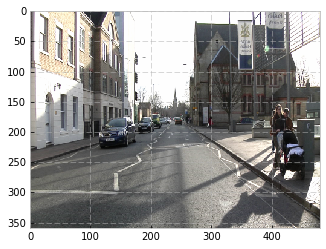

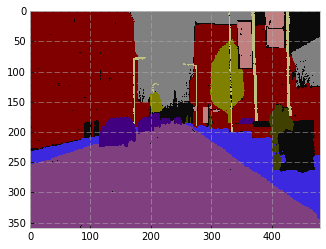

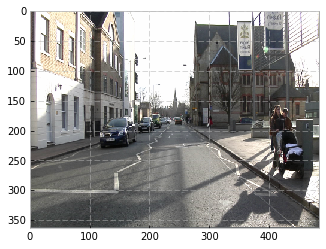

In [30]:
# Get a batch of training data
inputs, targets = next(iter(train_loader))
#inputs, targets = next(iter(val_loader))
#inputs, targets = next(iter(test_loader))

# Plot Single Image
view_image(inputs[0])

# Plot Target Image
view_annotated(targets[0])

# Plot Grid of images
out = torchvision.utils.make_grid(inputs, nrow=3)
view_image(out)

## Visdom web browser

* https://github.com/facebookresearch/visdom
* https://github.com/facebookresearch/visdom/blob/master/example/demo.py

In [34]:
visdom_enabled = True
import visdom
viz = visdom.Visdom()

In [46]:
def viz_plot_train_test(window, epoch, train_val, test_val, name='loss', env='main'):
    if window is None:
        return viz.line(
            X=np.array([epoch]),
            Y=np.array([[train_val, test_val]]),
            opts=dict(
                xlabel='epoch',
                ylabel=name,
                title=env+' '+name,
                legend=['Train','Validation']
            ),
            env=env
        )
    return viz.line(
        X=np.ones((1, 2)) * epoch,
        Y=np.expand_dims([train_val, test_val],0),
        win=window,
        update='append',
        env=env
    )

def viz_plot_img(window, tensor, env='main', title='Image'):
    '''
    This function draws an img on your Visdom web app. 
    It takes as input an `CxHxW` tensor `img`
    The array values can be float in [0,1] or uint8 in [0, 255]'''
    np_img = decode_image(tensor)
    np_img = np.rollaxis(np_img, 2, 0)
    viz.image(
        np_img,
        opts=dict(title=title, caption='Silly image'),
        win=window,
        env=env
    )
    
def viz_plot_text(window, text, env='main'):
    if window is None:
        return viz.text(
            text,
            env=env
        )
    return viz.text(
        text,
        win=window,
        env=env
    )

def viz_plot_summary(window, epoch, train_loss, test_loss,
                       train_err, test_err, env='main'):
    txt = ("""Epoch: %d
        Train - Loss: %.3f Err: %.3f
        Test - Loss: %.3f Err: %.3f""" % (epoch, 
        train_loss, train_err, test_loss, test_err))
    return viz_plot_text(window, txt, env)

In [41]:
txt_chart = viz_plot_summary(None, 1, 2, 3, 4, 5)
txt_chart = viz_plot_summary(txt_chart, 5, 2, 3, 4, 5)
txt_chart = viz_plot_summary(txt_chart, 5, 3, 8, 7, 6)

In [42]:
#Should plot one chart and update it
sum_chart = viz_plot_text(None, 'Hello, world3!')

In [43]:
sum_chart = viz_plot_text(sum_chart, 'Hello, world4!')

In [47]:
#Should plot one chart and update it
#window, epoch, test_val, train_val, name='loss', env='main'
#loss_chart = viz_plot_test_train(None, 9, 14, 27, 'loss')

#            viz_plot_train_test(None, epoch, train_loss, val_loss, 'loss')
loss_chart = viz_plot_train_test(None, 9, 14, 27, 'loss')

In [48]:
loss_chart = viz_plot_train_test(loss_chart,  10, 18, 30, 'loss')

In [49]:
loss_chart = viz_plot_train_test(loss_chart,  11, 19, 32, 'loss')

In [50]:
err_chart = viz_plot_train_test(None, 9, 14, 27, 'error')
err_chart = viz_plot_train_test(err_chart, 10, 18, 30, 'error')
err_chart = viz_plot_train_test(err_chart, 11, 19, 32, 'error')

In [52]:
inputs, targets = next(iter(train_loader))
img_chart = viz.image(
    np.random.rand(3,360,480),
    opts=dict(title="Image", caption='Silly random'),
)

In [68]:
a = torch.randn(2, 3)
a


 1.0329 -0.5380 -0.8986
-1.0348  0.7267  1.2167
[torch.FloatTensor of size 2x3]

In [70]:
value, indice = a.max(dim=0)
value, indice

(
  1.0329  0.7267  1.2167
 [torch.FloatTensor of size 1x3], 
  0  1  1
 [torch.LongTensor of size 1x3])

In [78]:
??Variable

In [79]:
def get_predictions(output_batch):
    # Variables(Tensors) of size (bs,12,224,224)
    bs,c,h,w = output_batch.size()
    tensor = output_batch.data
    # Argmax along channel axis (softmax probabilities)
    values, indices = tensor.cpu().max(1)   # max() can also return index of maximum
    indices = indices.view(bs,h,w)
    return indices

def error(preds, targets):
    assert preds.size() == targets.size()
    bs,h,w = preds.size()
    n_pixels = bs*h*w
    incorrect = preds.ne(targets).cpu().sum()
    err = 100.*incorrect/n_pixels
    return round(err,5)
        
def train(model, train_loader, optimizer, criterion, epoch):
    #Sets the module in training mode.
    model.train()
    train_loss = 0
    train_error = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = Variable(inputs.cuda()), Variable(targets.cuda())
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.data[0]
        pred = get_predictions(output)
        train_error += error(pred, targets.data.cpu())
    train_loss /= len(train_loader) #n_batches
    train_error /= len(train_loader)
    return train_loss, train_error

def test(model, test_loader, criterion, epoch=1):
    #Sets the module in evaluation mode. 
    model.eval()
    test_loss = 0
    test_error = 0
    for data, target in test_loader:
        #indicating that the Variable should be used in inference mode, not save in history
        data = Variable(data.cuda(), volatile=True)
        target = Variable(target.cuda())
        output = model(data)
        test_loss += criterion(output, target).data[0]
        pred = get_predictions(output)
        test_error += error(pred, target.data.cpu())
    test_loss /= len(test_loader) #n_batches
    test_error /= len(test_loader)
    return test_loss, test_error

def val(model, val_loader, criterion, epoch=1):
    #Sets the module in evaluation mode. 
    model.eval()
    val_loss = 0
    val_error = 0
    for data, target in val_loader:
        data = Variable(data.cuda(), volatile=True)
        target = Variable(target.cuda())
        output = model(data)
        val_loss += criterion(output, target).data[0]
        pred = get_predictions(output)
        val_error += error(pred, target.data.cpu())
    val_loss /= len(val_loader) #n_batches
    val_error /= len(val_loader)
    return val_loss, val_error

def adjust_learning_rate(lr, decay, optimizer, cur_epoch, n_epochs):
    """Sets the learning rate to the initially 
        configured `lr` decayed by `decay` every `n_epochs`"""
    # ref: https://discuss.pytorch.org/t/adaptive-learning-rate/320/4
    new_lr = lr * (decay ** (cur_epoch // n_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        #kaiming is first name of author whose last name is 'He' lol
        init.kaiming_uniform(m.weight) 
        m.bias.data.zero_()

## Config

* https://github.com/SimJeg/FC-DenseNet/blob/master/config/FC-DenseNet103.py

In [80]:
N_CLASSES = 12 #11 + background
seed = 0
LEARNING_RATE = 1e-4
LR_DECAY = 0.995 # Applied each epoch "exponential decay"
DECAY_LR_EVERY_N_EPOCHS = 1
WEIGHT_DECAY = 0.0001
N_EPOCHS = 1000
MAX_PATIENCE = 50

train_file = RESULTS_PATH+EXPERIMENT+'-train.csv'
test_file = RESULTS_PATH+EXPERIMENT+'-test.csv'
existing_weights_fpath=WEIGHTS_PATH+'latest.pth'
existing_optimizer_fpath=WEIGHTS_PATH+'latest-optim.pth'
cudnn.benchmark = True

In [ ]:
exp = Experiment('tiramisu13', '/data/code/mil_pytorch_tiramisu/')

## Experiment

In [81]:
class Experiment():
    def __init__(self, name, root):
        self.name = name
        self.root = os.path.join(root,name)
        self.epoch = 1
        self.best_val_loss = sys.maxsize
        self.best_val_loss_epoch = 1
        self.weights_dir = os.path.join(self.root, 'weights')
        self.history_dir = os.path.join(self.root, 'history')
        self.results_dir = os.path.join(self.root, 'results')
        self.latest_weights = os.path.join(self.weights_dir, 'latest_weights.pth')
        self.latest_optimizer = os.path.join(self.weights_dir, 'latest_optim.pth')
        self.best_weights_path = self.latest_weights
        self.best_optimizer_path = self.latest_optimizer
        self.train_history_fpath = os.path.join(self.history_dir, 'train.csv')
        self.val_history_fpath = os.path.join(self.history_dir, 'val.csv')
        self.test_history_fpath = os.path.join(self.history_dir, 'test.csv')
        self.loss_history = {
            'train': np.array([]),
            'val': np.array([]),
            'test': np.array([])
        } 
        self.error_history = {
            'train': np.array([]),
            'val': np.array([]),
            'test': np.array([])
        }
        self.visdom_plots = self.init_visdom_plots()

    def init(self):
        print("Creating new experiment")
        self.init_dirs()
        self.init_history_files()
        
    def resume(self, model, optim, weights_fpath=None, optim_path=None):
        print("Resuming existing experiment")
        if weights_fpath is None:
            weights_fpath = self.latest_weights
        if optim_path is None:
            optim_path = self.latest_optimizer
        
        model, state = self.load_weights(model, weights_fpath)
        optim = self.load_optimizer(optim, optim_path)
        
        self.best_val_loss = state['best_val_loss']
        self.best_val_loss_epoch = state['best_val_loss_epoch']
        self.epoch = state['last_epoch']+1
        self.load_history_from_file('train')
        self.load_history_from_file('val')
        
        return model, optim

    def init_dirs(self):
        os.makedirs(self.weights_dir)
        os.makedirs(self.history_dir)
        os.makedirs(self.results_dir)

    def init_history_files(self):
        Path(self.train_history_fpath).touch()
        Path(self.val_history_fpath).touch()
        Path(self.test_history_fpath).touch()
        
    def init_visdom_plots(self):
        loss = self.init_viz_train_plot('loss')
        error = self.init_viz_train_plot('error')
        summary = self.init_viz_txt_plot('summary')
        return {
            'loss':loss,
            'error':error,
            'summary':summary
        }

    def init_viz_train_plot(self, title):
        return viz.line(
            X=np.array([1]),
            Y=np.array([[1, 1]]),
            opts=dict(
                xlabel='epoch',
                ylabel=title,
                title=self.name+' '+title,
                legend=['Train', 'Validation']
            ),
            env=self.name
        )

    def init_viz_txt_plot(self, title):
        return viz.text(
            "Initializing.. " + title,
            env=self.name
        )    
    
    def viz_epochs(self):
        epochs = np.arange(1,self.epoch+1)
        return np.stack([epochs, epochs],1)
    
    def update_viz_loss_plot(self):
        loss = np.stack([self.loss_history['train'],
                         self.loss_history['val']],1)
        window = self.visdom_plots['loss']
        return viz.line(
            X=self.viz_epochs(),
            Y=loss,
            win=window,
            env=self.name,
            opts=dict(
                xlabel='epoch',
                ylabel='loss',
                title=self.name+' '+'loss',
                legend=['Train', 'Validation']
            ),
        )
    
    def update_viz_error_plot(self):
        error = np.stack([self.error_history['train'],
                         self.error_history['val']], 1)
        window = self.visdom_plots['error']
        return viz.line(
            X=self.viz_epochs(),
            Y=error,
            win=window,
            env=self.name,
            opts=dict(
                xlabel='epoch',
                ylabel='error',
                title=self.name+' '+'error',
                legend=['Train', 'Validation']
            )
        )
    
    def update_viz_summary_plot(self):
        train_loss = self.loss_history['train'][-1]
        val_loss = self.loss_history['val'][-1]
        #test_loss = self.loss_history['test'][-1]
        train_err = self.error_history['train'][-1]        
        val_err = self.error_history['val'][-1]
        #test_err = self.error_history['test'][-1]
        #txt = ("""Epoch: %d
        #    Train - Loss: %.3f Err: %.3f
        #    Test - Loss: %.3f Err: %.3f""" % (self.epoch, 
        #    trn_loss, trn_err, tst_loss, tst_err))
        txt = ("""Epoch: %d
            Train - Loss: %.3f Err: %.3f
            Val - Loss: %.3f Err: %.3f""" % (self.epoch, 
            train_loss, train_err, val_loss, val_err))
        window = self.visdom_plots['summary']
        return viz.text(
            txt,
            win=window,
            env=self.name
        )

    def load_history_from_file(self, dset_type):
        fpath = os.path.join(self.history_dir, dset_type+'.csv')
        data = np.loadtxt(fpath, delimiter=',').reshape(-1, 3)
        self.loss_history[dset_type] = data[:,1]
        self.error_history[dset_type] = data[:,2]
    
    def append_history_to_file(self, dset_type, loss, error):
        fpath = os.path.join(self.history_dir, dset_type+'.csv')
        with open(fpath, 'a') as f:
            f.write('{},{},{}\n'.format(self.epoch, loss, error))
    
    def save_history(self, dset_type, loss, error):
        self.loss_history[dset_type] = np.append(
            self.loss_history[dset_type], loss)
        self.error_history[dset_type] = np.append(
            self.error_history[dset_type], error)
        self.append_history_to_file(dset_type, loss, error)
        
        if dset_type == 'val' and self.is_best_loss(loss):
            self.best_val_loss = loss
            self.best_val_loss_epoch = self.epoch

    def is_best_loss(self, loss):
        return loss < self.best_val_loss
        
    def save_weights(self, model, train_loss, val_loss, train_err, val_err):
        weights_fname = self.name+'-weights-%d-%.3f-%.3f-%.3f-%.3f.pth' % (
            epoch, train_loss, train_err, val_loss, val_err)
        weights_fpath = os.path.join(self.weights_dir, weights_fname)
        torch.save({
                'last_epoch': self.epoch,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_err': train_err,
                'val_err': val_err,
                'best_val_loss': self.best_val_loss,
                'best_val_loss_epoch': self.best_val_loss_epoch,
                'experiment': self.name,
                'state_dict': model.state_dict()
            }, weights_fpath )
        shutil.copyfile(weights_fpath, self.latest_weights)
        if self.is_best_loss(val_loss):
            self.best_weights_path = weights_fpath

    def load_weights(self, model, fpath):
        print("loading weights '{}'".format(fpath))
        state = torch.load(fpath)
        model.load_state_dict(state['state_dict'])
        print (state['train_loss'], state['train_err'], state['val_loss'], state['val_err'])
        print("loaded weights from experiment %s (last_epoch %d, train_loss %s, train_err %s, val_loss %s, val_err %s)" % (
                  self.name, state['last_epoch'], state['train_loss'],
                    state['train_err'], state['val_loss'], state['val_err']))
        return model, state

    def save_optimizer(self, optimizer, val_loss):
        optim_fname = self.name+'-optim-%d.pth' % (epoch)
        optim_fpath = os.path.join(self.weights_dir, optim_fname)
        torch.save({
                'last_epoch': self.epoch,
                'experiment': self.name,
                'state_dict': optimizer.state_dict()
            }, optim_fpath )
        shutil.copyfile(optim_fpath, self.latest_optimizer)
        if self.is_best_loss(val_loss):
            self.best_optimizer_path = optim_fpath

    def load_optimizer(self, optimizer, fpath):
        print("loading optimizer '{}'".format(fpath))
        optim = torch.load(fpath)
        optimizer.load_state_dict(optim['state_dict'])
        print("loaded optimizer from session {}, last_epoch {}"
              .format(optim['experiment'], optim['last_epoch']))
        return optim
        

## Run

In [82]:
model = FCDenseNet103(n_classes=12).cuda()
print('  + Number of params: {}'.format(
    sum([p.data.nelement() for p in model.parameters()])))
model.apply(weights_init)
optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.NLLLoss2d(weight=camvid.class_weight.cuda()).cuda()

  + Number of params: 9322348


In [83]:
exp = Experiment('tiramisu_new', '/data/code/mil_pytorch_tiramisu/')

In [84]:
exp.init()

Creating new experiment


In [85]:
N_EPOCHS = 4 #2
START_EPOCH = exp.epoch
END_EPOCH = START_EPOCH+N_EPOCHS

In [86]:
for epoch in range(START_EPOCH, END_EPOCH):

    since = time.time()

    ### Train ###
    train_loss, train_err = train(model, train_loader, optimizer, criterion, epoch)
    print('Epoch {:d}: Train - Loss: {:.4f}\tErr: {:.4f}'.format(epoch, train_loss, train_err))    
    time_elapsed = time.time() - since  
    print('Train Time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    
    ### Val Test ###
    val_loss, val_err = val(model, val_loader, criterion, epoch)    
    print('Val - Loss: {:.4f}, Error: {:.4f}'.format(val_loss, val_err))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))

    ### Test ###
    #tst_loss, tst_err = test(model, test_loader, criterion, epoch)    
    #print('Test - Loss: {:.4f}, Error: {:.4f}'.format(tst_loss, tst_err))
    #time_elapsed = time.time() - since  
    #print('Total Time {:.0f}m {:.0f}s\n'.format(
    #    time_elapsed // 60, time_elapsed % 60))
    
    ### Save Metrics ###
    exp.save_history('train', train_loss, train_err)
    exp.save_history('val', val_loss, val_err)
    #exp.save_history('test', tst_loss, tst_err)
    
    ### Checkpoint ###    
    exp.save_weights(model, train_loss, val_loss, train_err, val_err)
    #exp.save_weights(model, trn_loss, tst_loss, trn_err, tst_err)
    exp.save_optimizer(optimizer, val_loss)
    #exp.save_optimizer(optimizer, tst_loss)

    
    ### Plot Online ###
    exp.update_viz_loss_plot()
    exp.update_viz_error_plot()
    exp.update_viz_summary_plot()
    
    
    ## Early Stopping ##
    if (epoch - exp.best_val_loss_epoch) > MAX_PATIENCE:
        print(("Early stopping at epoch %d since no " 
               + "better loss found since epoch %.3") 
               % (epoch, exp.best_val_loss))
        break


    ### Adjust Lr ###
    adjust_learning_rate(LEARNING_RATE, LR_DECAY, optimizer, 
                         epoch, DECAY_LR_EVERY_N_EPOCHS)
    
    exp.epoch += 1

Epoch 1: Train - Loss: 1.3155	Err: 35.2573
Train Time 2m 57s
Val - Loss: 1.5621, Error: 33.9745
Total Time 3m 12s

Epoch 2: Train - Loss: 1.0501	Err: 28.9537
Train Time 2m 50s
Val - Loss: 1.1967, Error: 36.2616
Total Time 3m 4s

Epoch 3: Train - Loss: 0.9465	Err: 26.1698
Train Time 2m 53s
Val - Loss: 1.3442, Error: 31.3884
Total Time 3m 7s

Epoch 4: Train - Loss: 0.8785	Err: 24.7159
Train Time 2m 53s
Val - Loss: 1.4870, Error: 31.2629
Total Time 3m 7s

